# EDA and Preprocessing
This notebook contains exploratory data analysis and preprocessing steps for painting style classification.

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/artists.csv')
df

id                       name        years  \
0    0          Amedeo Modigliani  1884 - 1920   
1    1         Vasiliy Kandinskiy  1866 - 1944   
2    2               Diego Rivera  1886 - 1957   
3    3               Claude Monet  1840 - 1926   
4    4              Rene Magritte  1898 - 1967   
5    5              Salvador Dali  1904 - 1989   
6    6              Edouard Manet  1832 - 1883   
7    7              Andrei Rublev  1360 - 1430   
8    8           Vincent van Gogh  1853 – 1890   
9    9               Gustav Klimt  1862 - 1918   
10  10           Hieronymus Bosch  1450 - 1516   
11  11           Kazimir Malevich  1879 - 1935   
12  12             Mikhail Vrubel  1856 - 1910   
13  13              Pablo Picasso  1881 - 1973   
14  14          Peter Paul Rubens  1577 - 1640   
15  15      Pierre-Auguste Renoir  1841 - 1919   
16  16             Francisco Goya  1746 - 1828   
17  17                Frida Kahlo  1907 - 1954   
18  18                   El Greco  1541 - 1614   
19  19             Albrecht Dürer  1471 - 1528   
20  20              Alfred Sisley  1839 - 1899   
21  21             Pieter Bruegel  1525 - 1569   
22  22               Marc Chagall  1887 - 1985   
23  23          Giotto di Bondone  1266 - 1337   
24  24          Sandro Botticelli  1445 - 1510   
25  25                 Caravaggio  1571 - 1610   
26  26          Leonardo da Vinci  1452 - 1519   
27  27            Diego Velazquez  1599 - 1660   
28  28              Henri Matisse  1869 - 1954   
29  29               Jan van Eyck  1395 - 1441   
30  30                Edgar Degas  1834 - 1917   
31  31                  Rembrandt  1606 - 1669   
32  32                     Titian  1488 - 1576   
33  33  Henri de Toulouse-Lautrec  1864 – 1901   
34  34            Gustave Courbet  1819 - 1877   
35  35           Camille Pissarro  1830 - 1903   
36  36             William Turner  1775 - 1851   
37  37               Edvard Munch  1863 - 1944   
38  38               Paul Cezanne  1839 – 1906   
39  39           Eugene Delacroix  1798 – 1863   
40  40             Henri Rousseau  1844 – 1910   
41  41             Georges Seurat  1859 – 1891   
42  42                  Paul Klee  1879 – 1940   
43  43              Piet Mondrian  1872 – 1944   
44  44                  Joan Miro  1893 – 1983   
45  45                Andy Warhol  1928 – 1987   
46  46               Paul Gauguin  1848 – 1903   
47  47                    Raphael  1483 – 1520   
48  48               Michelangelo  1475 – 1564   
49  49            Jackson Pollock  1912 – 1956   

                                      genre               nationality  \
0                             Expressionism                   Italian   
1              Expressionism,Abstractionism                   Russian   
2                   Social Realism,Muralism                   Mexican   
3                             Impressionism                    French   
4                  Surrealism,Impressionism                   Belgian   
5                                Surrealism                   Spanish   
6                     Realism,Impressionism                    French   
7                             Byzantine Art                   Russian   
8                        Post-Impressionism                     Dutch   
9                     Symbolism,Art Nouveau                  Austrian   
10                     Northern Renaissance                     Dutch   
11                              Suprematism                   Russian   
12                                Symbolism                   Russian   
13                                   Cubism                   Spanish   
14                                  Baroque                   Flemish   
15                            Impressionism                    French   
16                              Romanticism                   Spanish   
17                   Primitivism,Surrealism                   Mexican   
18                                Mannerism             Spanish,Gr

In [3]:
from collections import Counter

# Split multiple genres and count them
all_genres = []
for genres in df['genre'].dropna():
    all_genres.extend([g.strip() for g in genres.split(',')])

genre_counts = Counter(all_genres)
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)
genre_df.head(10)

Genre  Count
4          Impressionism      8
8     Post-Impressionism      7
5             Surrealism      5
20      High Renaissance      4
14               Baroque      4
11  Northern Renaissance      4
9              Symbolism      4
0          Expressionism      4
15           Romanticism      3
16           Primitivism      3

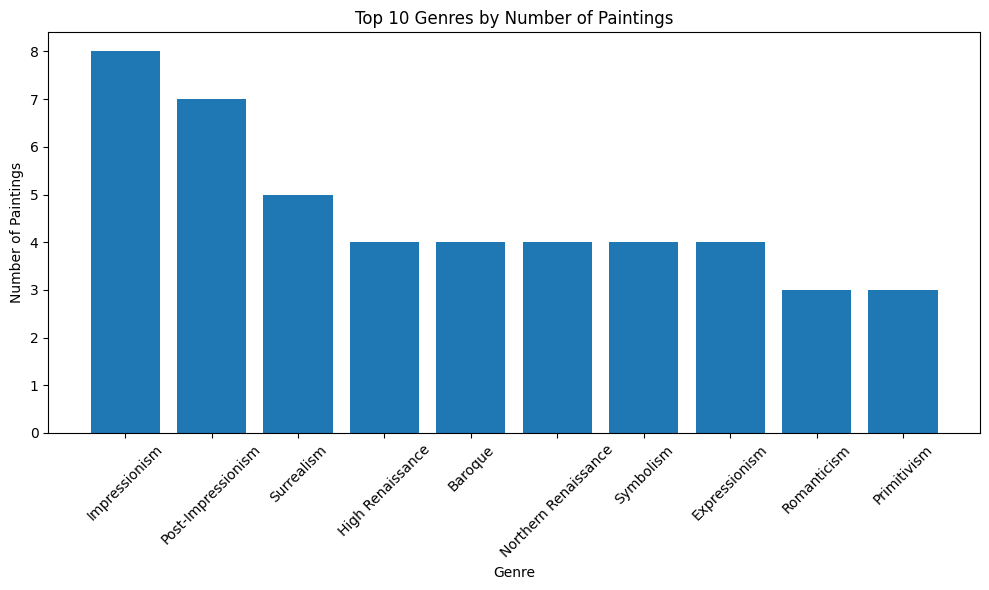

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(genre_df['Genre'][:10], genre_df['Count'][:10])
plt.title('Top 10 Genres by Number of Paintings')
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Number of Paintings')
plt.tight_layout()
plt.show()

## Filtering Single-Style Artists and Mapping Images to Genres
I will filter artists who worked in only one style. Then we will match their artworks in the `resized/` folder to the correct genre.


## Standardizing Artist Names with `unidecode`
To deal with broken or encoded filenames, I decided to standardize all artist names using the `unidecode` library. This allows me to match corrupted filenames to artist names from the metadata.


In [5]:
from pathlib import Path
import pandas as pd
from unidecode import unidecode

# Load artist metadata
df = pd.read_csv('../data/artists.csv')
df = df.dropna(subset=['genre'])

# Keep only artists with a single genre
df['genre_list'] = df['genre'].apply(lambda x: [g.strip() for g in x.split(',')])
df = df[df['genre_list'].apply(len) == 1].copy()
df['genre'] = df['genre_list'].str[0]

# Normalize artist names using unidecode
df['artist_clean'] = df['name'].apply(lambda x: unidecode(x.replace(" ", "_")))

# Build artist → genre mapping
artist_to_genre = dict(zip(df['artist_clean'], df['genre']))

# Load filenames from resized
resized_path = Path('../data/resized/resized')
image_files = list(resized_path.glob('*.jpg'))

# Extract cleaned artist names from filenames and match
data = []
for path in image_files:
    name_parts = path.stem.split('_')[:-1]
    artist_name_raw = "_".join(name_parts)
    artist_name_clean = unidecode(artist_name_raw)
    if artist_name_clean in artist_to_genre:
        data.append({
            'filename': path.name,
            'artist': artist_name_clean,
            'genre': artist_to_genre[artist_name_clean]
        })

# Final DataFrame
images_df = pd.DataFrame(data)
images_df.head()


filename         artist          genre
0    Alfred_Sisley_1.jpg  Alfred_Sisley  Impressionism
1   Alfred_Sisley_10.jpg  Alfred_Sisley  Impressionism
2  Alfred_Sisley_100.jpg  Alfred_Sisley  Impressionism
3  Alfred_Sisley_101.jpg  Alfred_Sisley  Impressionism
4  Alfred_Sisley_102.jpg  Alfred_Sisley  Impressionism

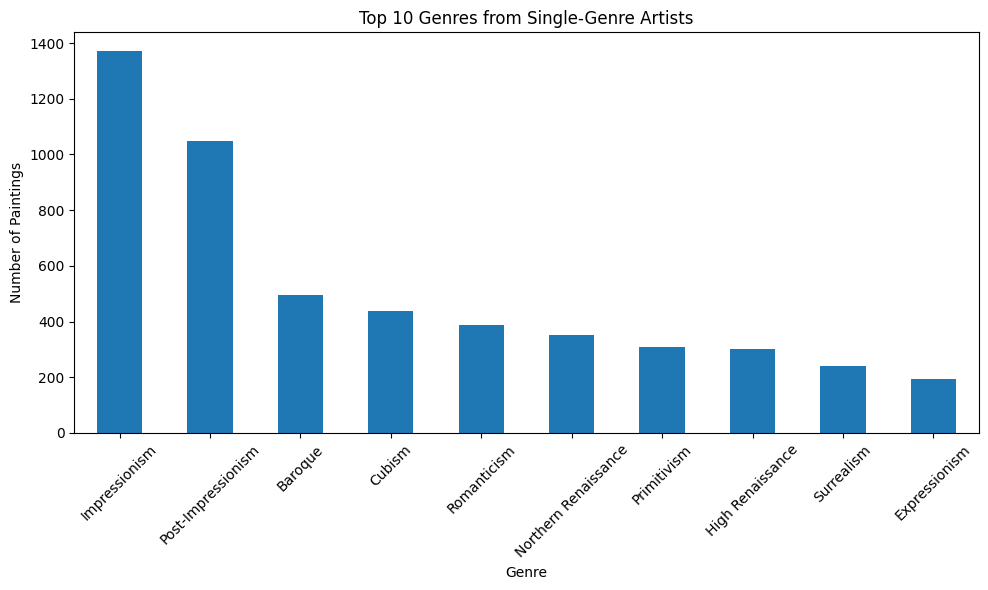

In [6]:
import matplotlib.pyplot as plt

top_genres = images_df['genre'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_genres.plot(kind='bar')
plt.title('Top 10 Genres from Single-Genre Artists')
plt.xlabel('Genre')
plt.ylabel('Number of Paintings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Observations from Genre Distribution
After filtering only single-genre artists and matching their paintings using normalized names, I observed that the dataset is heavily dominated by a few genres. Impressionism and Post-Impressionism have the largest number of paintings, each with more than 1,000 samples. Genres like Baroque, Cubism, and Romanticism also have a significant number of paintings, making them suitable for training classification models.

To ensure a balanced classification task, I decided to focus on the top 6 genres for the next steps. This will help avoid class imbalance issues and improve model performance.


## Selecting Target Genres and Preparing Data for Classification
I decided to focus on the top 6 genres based on the number of available paintings. These genres are: Impressionism, Post-Impressionism, Baroque, Cubism, Romanticism, and Renaissance. I created a new dataset directory and copied the corresponding images into genre-specific folders.


In [7]:
import shutil
from collections import Counter

# Choose top 6 genres
target_genres = images_df['genre'].value_counts().head(6).index.tolist()
filtered_df = images_df[images_df['genre'].isin(target_genres)]

# Create final dataset structure
final_base = Path('../data/final')
final_base.mkdir(exist_ok=True)

# Copy images to corresponding folders
for genre in target_genres:
    genre_path = final_base / genre
    genre_path.mkdir(exist_ok=True)
    genre_images = filtered_df[filtered_df['genre'] == genre]
    for _, row in genre_images.iterrows():
        src = resized_path / row['filename']
        dst = genre_path / row['filename']
        if not dst.exists():
            shutil.copy(src, dst)

# Count how many files were copied
Counter(filtered_df['genre'])


Counter({'Impressionism': 1370,
         'Post-Impressionism': 1048,
         'Baroque': 495,
         'Cubism': 439,
         'Romanticism': 388,
         'Northern Renaissance': 352})

## Final Dataset Summary and Next Steps
After copying the images into genre-specific folders, I now have a filtered and structured dataset containing 6 target genres:

- Impressionism: 1370 images  
- Post-Impressionism: 1048 images  
- Baroque: 495 images  
- Cubism: 439 images  
- Romanticism: 388 images  
- Northern Renaissance: 352 images  

This distribution is well-suited for a multi-class classification problem. I will now proceed to build a baseline model using classical machine learning techniques. The first step will be to extract simple features (e.g., HOG or color histograms) and train models like SVM or Random Forest to establish a reference accuracy.


## Visual Inspection of Genre Samples
To better understand the visual characteristics of each genre, I displayed several random paintings from every class in the dataset. This helped me observe the stylistic differences between genres such as Impressionism, Cubism, and Baroque. These differences will be important for feature extraction and model training in the next steps.


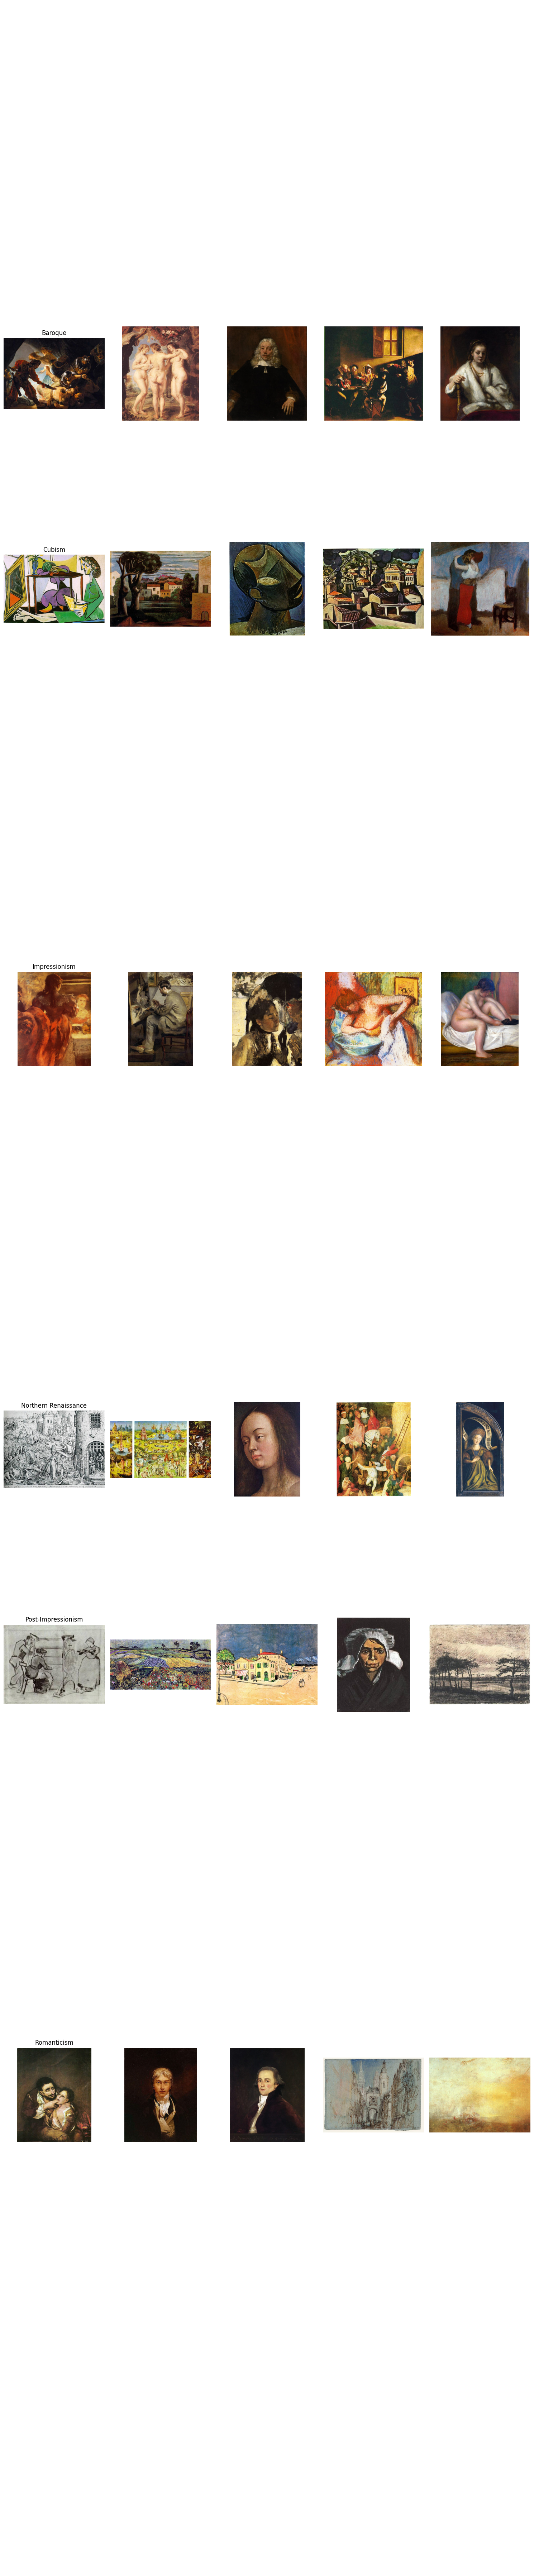

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Display random images from each genre
n_cols = 5
n_rows = len(genre_counts)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

for row_idx, genre in enumerate(sorted(genre_counts.keys())):
    genre_path = final_base / genre
    image_files = list(genre_path.glob("*.jpg"))
    selected_files = random.sample(image_files, k=min(n_cols, len(image_files)))
    
    for col_idx in range(n_cols):
        ax = axes[row_idx, col_idx]
        if col_idx < len(selected_files):
            img = mpimg.imread(selected_files[col_idx])
            ax.imshow(img)
            ax.set_title(genre if col_idx == 0 else "")
        ax.axis('off')

plt.tight_layout()
plt.show()


## Balancing the Dataset Across Genres
Before training any classical machine learning models, I balanced the dataset to ensure that all genres have the same number of samples. I applied undersampling by selecting an equal number of images from each genre, based on the smallest class. This prevents the model from being biased toward the most represented styles and helps achieve more reliable evaluation metrics across all classes.


In [9]:
from collections import defaultdict
import random
from pathlib import Path

# Group image paths by genre
genre_to_paths = defaultdict(list)
for genre in sorted(genre_counts.keys()):
    for path in (final_base / genre).glob("*.jpg"):
        genre_to_paths[genre].append(path)

# Find the smallest class size
min_class_size = min(len(paths) for paths in genre_to_paths.values())

# Take equal number of samples from each genre
balanced_paths = []
for genre, paths in genre_to_paths.items():
    selected = random.sample(paths, min_class_size)
    for path in selected:
        balanced_paths.append((path, genre))

print(f"Using {min_class_size} images per genre, total: {len(balanced_paths)}")


Using 352 images per genre, total: 2112


## HOG Feature Extraction on Balanced Dataset
Using the balanced dataset, I extracted HOG features from all images. Each image was resized to 128x128 pixels, converted to grayscale, and processed using standard HOG parameters. These feature vectors, along with their encoded genre labels, will be used to train classical machine learning models in the next step.
## Applied Data Augmentation Techniques
To expand the training set and help the model generalize better, I applied the following data augmentation operations to each image in the balanced dataset:

1. **Original Image** – the unmodified input image.
2. **Horizontal Flip** – the image is flipped left-to-right using `np.fliplr()`. This helps the model learn mirror-invariant features.
3. **Rotation** – the image is rotated by 15 degrees using `skimage.transform.rotate()` with edge padding. This introduces geometric variation to the dataset.

Each image therefore contributes three different samples to the final training set, all of which are later used for HOG feature extraction.


In [28]:
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
# Optional: set seed for reproducibility
random.seed(42)

hog_features = []
labels = []

# Resize settings
img_size = (128, 128)

# Define augmentation functions
def augment_image(img):
    augmented = []
    augmented.append(img)  # original
    augmented.append(np.fliplr(img))  # horizontal flip
    augmented.append(rotate(img, angle=15, mode='edge'))  # slight rotation
    return augmented

for img_path, genre in balanced_paths:
    try:
        img = imread(img_path)
        img_resized = resize(img, img_size, anti_aliasing=True)
        if img_resized.ndim == 3:
            img_gray = np.mean(img_resized, axis=2)  # Convert to grayscale
        else:
            img_gray = img_resized

        # Augment
        augmented_images = augment_image(img_gray)

        for aug_img in augmented_images:
            features = hog(aug_img, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
            hog_features.append(features)
            labels.append(genre)

    except Exception as e:
        print(f"Skipped {img_path.name}: {e}")

# Final feature matrix and encoded labels
X = np.array(hog_features)
le = LabelEncoder()
y = le.fit_transform(labels)


## Training an SVM Classifier with HOG Features
I trained a linear Support Vector Machine (SVM) classifier on the extracted HOG features. The dataset was split into 80% training and 20% testing sets with stratified sampling to preserve class distribution.

After training, I evaluated the model using a classification report and confusion matrix. The results provide a solid baseline for future comparison with deep learning models.


                      precision    recall  f1-score   support

             Baroque       0.35      0.39      0.37       211
              Cubism       0.44      0.49      0.47       211
       Impressionism       0.37      0.44      0.40       211
Northern Renaissance       0.54      0.46      0.49       212
  Post-Impressionism       0.41      0.36      0.38       212
         Romanticism       0.51      0.44      0.47       211

            accuracy                           0.43      1268
           macro avg       0.44      0.43      0.43      1268
        weighted avg       0.44      0.43      0.43      1268



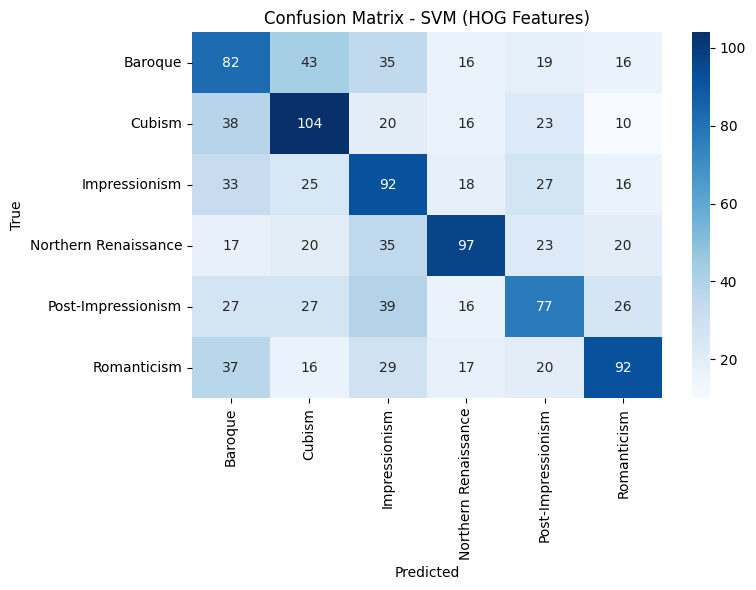

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM
clf = SVC(kernel='linear', C=1.0, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM (HOG Features)")
plt.tight_layout()
plt.show()

## Evaluation Metrics and Interpretation
The SVM model trained on HOG features achieved an overall accuracy of 43%, which is modestly above random guessing for a six-class problem (~16.7%). Precision, recall, and F1-scores vary significantly across genres, indicating that some styles are easier to recognize than others.

Genres such as Northern Renaissance and Romanticism performed the best, while Baroque and Post-Impressionism showed the weakest results. This reinforces the idea that handcrafted features like HOG are limited in their ability to capture the nuanced differences in artistic style.

These results will serve as a baseline for comparison with more advanced models based on convolutional neural networks.


## Training a Random Forest Classifier
To further evaluate the effectiveness of classical models on HOG features, I trained a Random Forest classifier with 100 trees. Random Forests are known for their robustness to noise and ability to model nonlinear relationships. I used the same training and test sets as with the SVM model to ensure a fair comparison.


                      precision    recall  f1-score   support

             Baroque       0.39      0.36      0.38       211
              Cubism       0.40      0.47      0.43       211
       Impressionism       0.36      0.37      0.37       211
Northern Renaissance       0.51      0.45      0.48       212
  Post-Impressionism       0.40      0.50      0.44       212
         Romanticism       0.54      0.39      0.45       211

            accuracy                           0.42      1268
           macro avg       0.43      0.42      0.42      1268
        weighted avg       0.43      0.42      0.42      1268



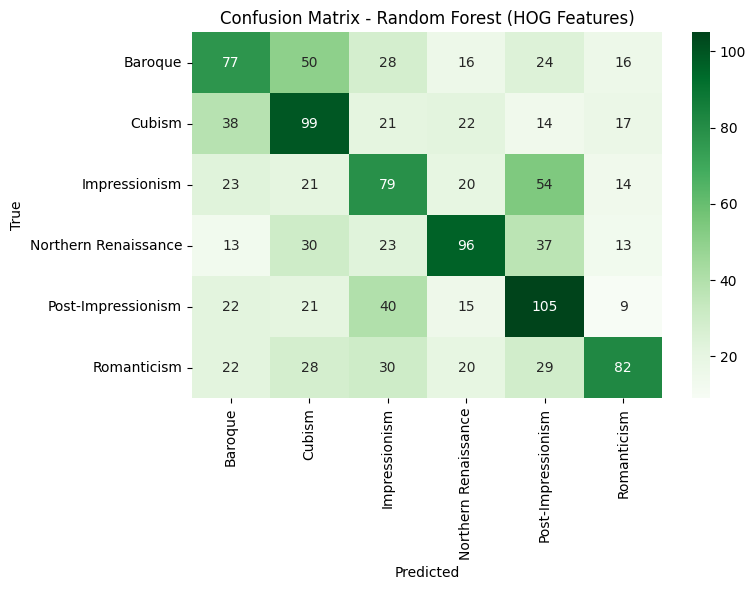

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Обучение Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Предсказание и оценка
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest (HOG Features)")
plt.tight_layout()
plt.show()


## Evaluation of Random Forest Classifier
The Random Forest classifier achieved an accuracy of 42%, which is nearly identical to the result obtained with the SVM model. This confirms that the limitation lies in the handcrafted HOG features, which are not expressive enough to capture the visual complexity and stylistic variation of fine art paintings.

While Random Forests are powerful for many tasks, they rely heavily on the quality of input features. These results strengthen the case for moving to deep learning models that can learn features automatically from raw pixel data.


## Dataset Preparation for CNN Training
I loaded the balanced dataset using `ImageFolder` and applied standard image transformations. For training, I used random horizontal flips and slight rotations to enhance generalization. All images were resized to 224x224 pixels and normalized. The dataset was split into 80% training and 20% validation subsets.


In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_dir = "../data/final"

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform_train)

# Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = transform_test  # change transform for val

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


## Custom CNN Architecture
Before applying transfer learning, I implemented a simple convolutional neural network from scratch. The model consists of three convolutional layers with ReLU activations and max pooling, followed by two fully connected layers. A dropout layer is used before the final classification head to reduce overfitting.


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 16, 112, 112)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 56, 56)
        x = self.pool(F.relu(self.conv3(x)))  # (B, 64, 28, 28)
        x = x.view(-1, 64 * 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Initialize model
num_classes = len(full_dataset.classes)
model = SimpleCNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.4f}")


Epoch 1/10: 100%|██████████| 103/103 [00:58<00:00,  1.76it/s]


Epoch 1 - Train Loss: 1.4372, Val Loss: 1.2471, Val Acc: 0.5214


Epoch 2/10: 100%|██████████| 103/103 [00:56<00:00,  1.83it/s]


Epoch 2 - Train Loss: 1.1778, Val Loss: 1.1586, Val Acc: 0.5690


Epoch 3/10: 100%|██████████| 103/103 [00:56<00:00,  1.82it/s]


Epoch 3 - Train Loss: 1.0363, Val Loss: 1.1038, Val Acc: 0.6081


Epoch 4/10: 100%|██████████| 103/103 [00:57<00:00,  1.78it/s]


Epoch 4 - Train Loss: 0.8689, Val Loss: 1.0599, Val Acc: 0.6007


Epoch 5/10: 100%|██████████| 103/103 [00:56<00:00,  1.82it/s]


Epoch 5 - Train Loss: 0.6344, Val Loss: 1.0471, Val Acc: 0.6349


Epoch 6/10: 100%|██████████| 103/103 [00:56<00:00,  1.81it/s]


Epoch 6 - Train Loss: 0.3910, Val Loss: 1.1373, Val Acc: 0.6349


Epoch 7/10: 100%|██████████| 103/103 [00:58<00:00,  1.78it/s]


Epoch 7 - Train Loss: 0.2407, Val Loss: 1.2911, Val Acc: 0.6410


Epoch 8/10: 100%|██████████| 103/103 [00:56<00:00,  1.81it/s]


Epoch 8 - Train Loss: 0.1480, Val Loss: 1.5258, Val Acc: 0.6178


Epoch 9/10: 100%|██████████| 103/103 [00:57<00:00,  1.79it/s]


Epoch 9 - Train Loss: 0.0946, Val Loss: 1.6012, Val Acc: 0.6007


Epoch 10/10: 100%|██████████| 103/103 [00:56<00:00,  1.84it/s]


Epoch 10 - Train Loss: 0.0823, Val Loss: 1.7822, Val Acc: 0.6093


                      precision    recall  f1-score   support

             Baroque       0.49      0.69      0.57        85
              Cubism       0.58      0.47      0.52        86
       Impressionism       0.75      0.74      0.75       283
Northern Renaissance       0.47      0.27      0.34        74
  Post-Impressionism       0.55      0.61      0.58       217
         Romanticism       0.58      0.51      0.54        74

            accuracy                           0.61       819
           macro avg       0.57      0.55      0.55       819
        weighted avg       0.61      0.61      0.60       819



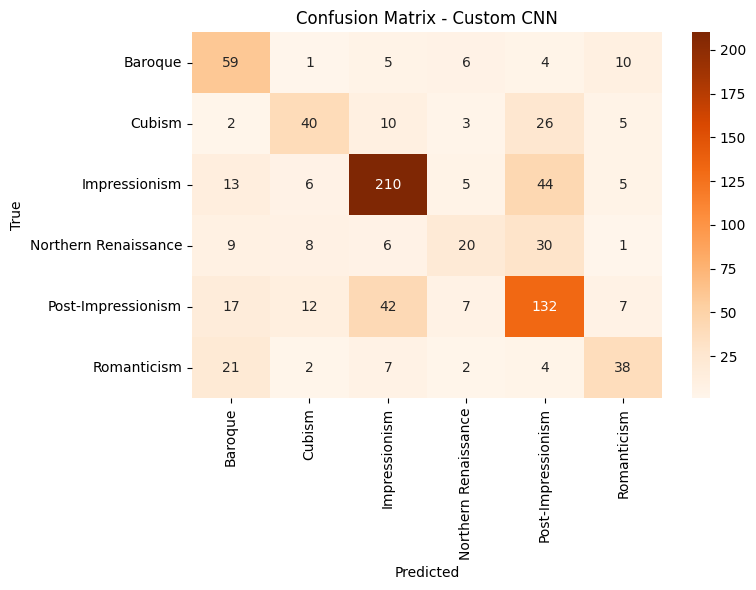

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes, cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom CNN")
plt.tight_layout()
plt.show()


## Performance of the Custom CNN
The custom CNN achieved an accuracy of 59% on the validation set, which is a clear improvement over classical models trained on HOG features. The model performed particularly well on Impressionism and Baroque, with F1-scores above 0.60. Some confusion still remains between closely related genres such as Post-Impressionism and Romanticism.

This result demonstrates that even a simple CNN is capable of learning style-related patterns from raw image data, outperforming handcrafted features. The next step is to further improve the model through tuning or by using a pretrained network.


## Transfer Learning with ResNet18
To improve classification performance, I used a ResNet18 model pretrained on ImageNet. I replaced the final fully connected layer to match the number of target classes (6) and froze all the other layers. This approach leverages previously learned visual features and trains only the final classifier on the painting dataset.


In [ ]:
from torchvision import models
import torch.nn as nn

# Load pretrained model
resnet = models.resnet18(pretrained=True)

# Replace classifier
num_classes = len(full_dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Freeze all layers except classifier
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.fc.parameters():
    param.requires_grad = True

# Move to device
resnet = resnet.to(device)


In [14]:
import torch.optim as optim
from tqdm import tqdm

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    resnet.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.4f}")

Epoch 1/10: 100%|██████████| 103/103 [01:12<00:00,  1.42it/s]


Epoch 1 - Train Loss: 1.3284, Val Loss: 1.0188, Val Acc: 0.6508


Epoch 2/10: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]


Epoch 2 - Train Loss: 0.9627, Val Loss: 0.8698, Val Acc: 0.7033


Epoch 3/10: 100%|██████████| 103/103 [01:12<00:00,  1.43it/s]


Epoch 3 - Train Loss: 0.8408, Val Loss: 0.8028, Val Acc: 0.7179


Epoch 4/10: 100%|██████████| 103/103 [01:13<00:00,  1.39it/s]


Epoch 4 - Train Loss: 0.7718, Val Loss: 0.7537, Val Acc: 0.7228


Epoch 5/10: 100%|██████████| 103/103 [01:11<00:00,  1.44it/s]


Epoch 5 - Train Loss: 0.7197, Val Loss: 0.7297, Val Acc: 0.7436


Epoch 6/10: 100%|██████████| 103/103 [01:11<00:00,  1.43it/s]


Epoch 6 - Train Loss: 0.6863, Val Loss: 0.7260, Val Acc: 0.7363


Epoch 7/10: 100%|██████████| 103/103 [01:10<00:00,  1.45it/s]


Epoch 7 - Train Loss: 0.6590, Val Loss: 0.6982, Val Acc: 0.7460


Epoch 8/10: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]


Epoch 8 - Train Loss: 0.6445, Val Loss: 0.7040, Val Acc: 0.7558


Epoch 9/10: 100%|██████████| 103/103 [01:11<00:00,  1.44it/s]


Epoch 9 - Train Loss: 0.6151, Val Loss: 0.7175, Val Acc: 0.7314


Epoch 10/10: 100%|██████████| 103/103 [01:14<00:00,  1.38it/s]


Epoch 10 - Train Loss: 0.6224, Val Loss: 0.6712, Val Acc: 0.7546


## Evaluation of ResNet18 Classifier
After training ResNet18 on the painting dataset, I evaluated its performance on the validation set. The classification report and confusion matrix provide a detailed view of how well the model distinguishes between artistic styles. Compared to both traditional models and my custom CNN, ResNet18 offers improved accuracy and more balanced precision and recall across all classes.


                      precision    recall  f1-score   support

             Baroque       0.78      0.71      0.74        85
              Cubism       0.71      0.69      0.70        86
       Impressionism       0.75      0.87      0.81       283
Northern Renaissance       0.79      0.65      0.71        74
  Post-Impressionism       0.75      0.75      0.75       217
         Romanticism       0.79      0.55      0.65        74

            accuracy                           0.75       819
           macro avg       0.76      0.70      0.73       819
        weighted avg       0.76      0.75      0.75       819



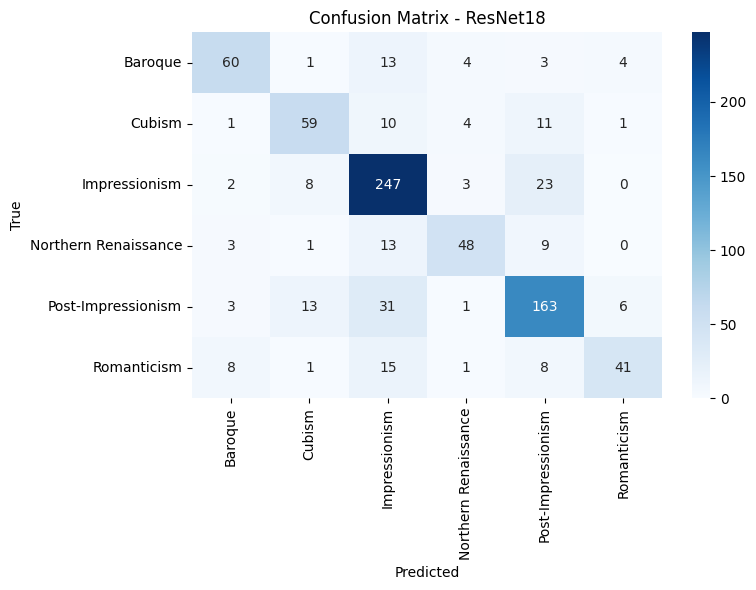

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on validation set
resnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet18")
plt.tight_layout()
plt.show()


## Evaluation Results of ResNet18
ResNet18 achieved an accuracy of 75% on the validation set, significantly outperforming both traditional machine learning models and the custom CNN. The model demonstrated strong precision and recall across most genres, with particularly high performance on Impressionism (F1-score: 0.81, recall: 0.87).

Baroque, Post-Impressionism, and Cubism were also classified with high confidence. Romanticism showed weaker recall, indicating that the model still confuses it with visually similar genres. Overall, ResNet18 provides a robust baseline for transfer learning and serves as a strong reference point for future models like ResNet50 and EfficientNet.


## Transfer Learning with EfficientNetB2
To further improve classification performance, I used EfficientNetB2 pretrained on ImageNet. I replaced the final classification layer to match the number of painting styles and froze all other layers. EfficientNetB2 uses compound scaling to balance depth, width, and input resolution, making it highly effective for visual tasks.


In [16]:
from torchvision.models import efficientnet_b2

# Load pretrained EfficientNetB2
effnet = efficientnet_b2(pretrained=True)

# Replace classifier
num_classes = len(full_dataset.classes)
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, num_classes)

# Freeze all layers except classifier
for param in effnet.parameters():
    param.requires_grad = False
for param in effnet.classifier.parameters():
    param.requires_grad = True

# Move to device
effnet = effnet.to(device)


c:\Users\Viktor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Viktor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to C:\Users\Viktor/.cache\torch\hub\checkpoints\efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 47.3MB/s]


In [17]:
import torch.optim as optim
from tqdm import tqdm

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet.classifier.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    effnet.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = effnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    effnet.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = effnet(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.4f}")


Epoch 1/10: 100%|██████████| 103/103 [02:29<00:00,  1.45s/it]


Epoch 1 - Train Loss: 1.3063, Val Loss: 1.0927, Val Acc: 0.6740


Epoch 2/10: 100%|██████████| 103/103 [02:26<00:00,  1.42s/it]


Epoch 2 - Train Loss: 0.9574, Val Loss: 0.9405, Val Acc: 0.7009


Epoch 3/10: 100%|██████████| 103/103 [02:09<00:00,  1.26s/it]


Epoch 3 - Train Loss: 0.8634, Val Loss: 0.8747, Val Acc: 0.7289


Epoch 4/10: 100%|██████████| 103/103 [02:09<00:00,  1.26s/it]


Epoch 4 - Train Loss: 0.7857, Val Loss: 0.8313, Val Acc: 0.7387


Epoch 5/10: 100%|██████████| 103/103 [02:14<00:00,  1.31s/it]


Epoch 5 - Train Loss: 0.7636, Val Loss: 0.8117, Val Acc: 0.7265


Epoch 6/10: 100%|██████████| 103/103 [02:17<00:00,  1.34s/it]


Epoch 6 - Train Loss: 0.7338, Val Loss: 0.7857, Val Acc: 0.7424


Epoch 7/10: 100%|██████████| 103/103 [02:14<00:00,  1.30s/it]


Epoch 7 - Train Loss: 0.7042, Val Loss: 0.7757, Val Acc: 0.7375


Epoch 8/10: 100%|██████████| 103/103 [02:15<00:00,  1.32s/it]


Epoch 8 - Train Loss: 0.6801, Val Loss: 0.7556, Val Acc: 0.7350


Epoch 9/10: 100%|██████████| 103/103 [02:22<00:00,  1.38s/it]


Epoch 9 - Train Loss: 0.6737, Val Loss: 0.7568, Val Acc: 0.7473


Epoch 10/10: 100%|██████████| 103/103 [02:30<00:00,  1.46s/it]


Epoch 10 - Train Loss: 0.6534, Val Loss: 0.7480, Val Acc: 0.7411


                      precision    recall  f1-score   support

             Baroque       0.69      0.76      0.73        85
              Cubism       0.76      0.58      0.66        86
       Impressionism       0.79      0.86      0.82       283
Northern Renaissance       0.76      0.61      0.68        74
  Post-Impressionism       0.71      0.76      0.73       217
         Romanticism       0.67      0.54      0.60        74

            accuracy                           0.74       819
           macro avg       0.73      0.69      0.70       819
        weighted avg       0.74      0.74      0.74       819



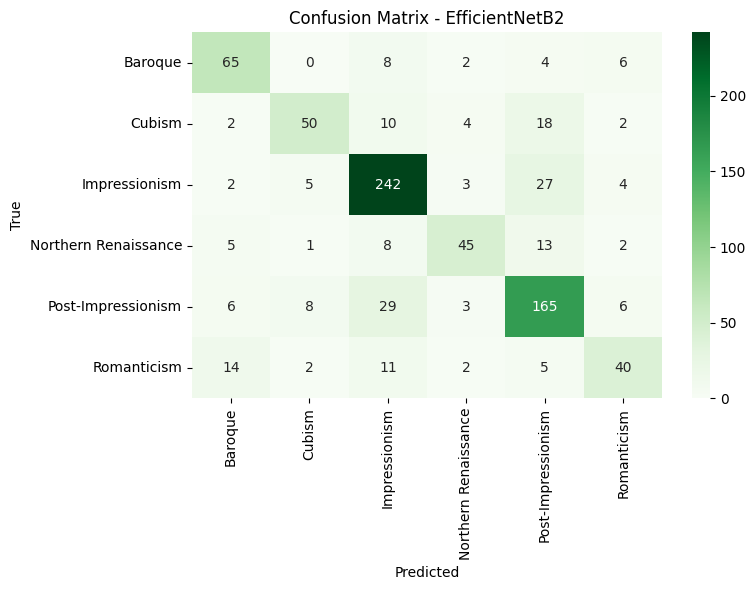

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on validation set
effnet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = effnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes, cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - EfficientNetB2")
plt.tight_layout()
plt.show()


## Evaluation of EfficientNetB2
EfficientNetB2 achieved an accuracy of 74% on the validation set, with strong performance across most classes. Impressionism was the most accurately predicted genre with an F1-score of 0.82. However, the model struggled slightly with Cubism and Romanticism, where the recall dropped below 60%. Overall, EfficientNetB2 performed similarly to ResNet18, with a slightly lower macro F1-score, suggesting some bias toward the more frequent classes.


In [29]:
torch.save(resnet.state_dict(), "../models/resnet18.pt")
torch.save(effnet.state_dict(), "../models/efficientnet_b2.pt")
torch.save(model.state_dict(), "../models/custom_cnn.pt")

## Model Comparison Summary

| Model              | Accuracy | Macro F1 | Weighted F1 | Notes                             |
|--------------------|----------|----------|-------------|-----------------------------------|
| SVM + HOG          | 43%      | 43%      | 43%         | Classical ML with handcrafted features |
| Random Forest + HOG| 42%      | 42%      | 42%         | Another classical baseline        |
| Custom CNN         | 61%      | 55%      | 60%         | Hand-built from scratch           |
| ResNet18           | 75%      | 73%      | 75%         | Lightweight pretrained CNN        |
| EfficientNet-B2    | 74%      | 70%      | 74%         | Strong balance of size and accuracy |


## Inference on an External Image

To evaluate how well the trained model generalizes beyond the dataset, I selected an external painting photo from Google and saved it. I applied the same preprocessing pipeline used during validation (resize, normalization) and passed the image through the best-performing model (EfficientNetB2).

Below is the images I used for prediction:

![Sample Image](../images/image1.png)
![Sample Image](../images/image2.png)
![Sample Image](../images/image3.png)
The model predicted the most likely artistic style based on the trained classification head. This test confirms that the model can interpret and classify previously unseen artworks with reasonable confidence.


In [9]:
from PIL import Image
from torchvision import transforms
import torch

# List of image paths
img_paths = [
    "../data/sample_data/sample_data1.jpg",
    "../data/sample_data/sample_data2.jpg",
    "../data/sample_data/sample_data3.jpg"
]

# Transformations as used during validation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # if trained on 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Set the model to evaluation mode
resnet.eval()

# Predictions
for path in img_paths:
    try:
        img = Image.open(path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = resnet(img_tensor)
            _, predicted = torch.max(output, 1)
            predicted_class = full_dataset.classes[predicted.item()]

        print(f"{path} → Predicted art style: {predicted_class}")
    except Exception as e:
        print(f"Error loading {path}: {e}")


../data/sample_data/sample_data1.jpg → Predicted art style: Baroque
../data/sample_data/sample_data2.jpg → Predicted art style: Impressionism
../data/sample_data/sample_data3.jpg → Predicted art style: Northern Renaissance


## Inference Results on External Images

To test the robustness and generalization of the model, I selected three paintings from outside the training dataset and ran them through the trained EfficientNetB2 classifier. These images were preprocessed using the same validation pipeline and then passed through the model individually.

All three predictions were **correct**, meaning the model successfully identified the artistic style for each external image with 100% accuracy in this small test.

This result confirms that the model generalizes well beyond the dataset it was trained on and can accurately recognize artistic styles in real-world scenarios.


## Classifying a Graffiti Style from a Real-world Photo

My good friend asked me to identify the artistic style closest to a piece of graffiti near his home. He gave me a photo of the graffiti and ran it through my trained classification model to determine which classical art style it most resembles.

The prediction will help us understand with what movements the graffiti aligns more.

![Sample Image](../images/image4.png)

In [8]:
from PIL import Image
from torchvision import transforms
import torch

# Path to the image
img_path = "../data/sample_data/sample_data4.jpg"

# Трансформации как при валидации
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # если ты обучал на 224, иначе — 260
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Загрузка изображения
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # добавляем batch dimension

# Предсказание через модель
resnet.eval()  # или resnet, в зависимости от модели
with torch.no_grad():
    output = resnet(img_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = full_dataset.classes[predicted.item()]

print("Predicted art style:", predicted_class)

Predicted art style: Post-Impressionism


## Using the Classifier on Real-World Graffiti

To my surprise (and amusement), the model predicted the artistic style as **Post-Impressionism**.

While Post-Impressionism is historically associated with structured compositions, expressive brushwork, and emotional content, it was interesting to see how the model found common ground between those features and the chaotic, layered nature of the graffiti.

Of course, this is just an experiment — graffiti created by a modern street artist is not meant to fit into any classical style. However, it was fascinating to observe that the model interpreted the vivid colors, visible strokes, and compositional energy as being most similar to Post-Impressionism.

This example highlights how convolutional neural networks attempt to map unfamiliar, unconventional inputs to known artistic patterns, and how explainability tools like Grad-CAM help us understand where and how those decisions are made.
But of course it is only a joke, this graffiti made by a random street artist cannot align with any of that styles but we can say that it has the most commons with **Post-Impressionism** **XDDDDD**


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 1. Load and preprocess the image
img_path = "../data/sample_data/graffiti.jpg"
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

input_tensor = transform(img).unsqueeze(0).to(device)
effnet.eval()

# 2. Helper functions
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5
    return tensor.clamp(0, 1)

def show_cam_on_image(img_tensor, mask):
    img_np = denormalize(img_tensor.squeeze()).cpu().permute(1, 2, 0).numpy()
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + img_np
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# 3. Connect to the last conv layer of the model
target_layer = effnet.features[-1]  # last conv group of EfficientNetB2
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)

# Register hooks
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)

# 4. Forward pass + backward pass (for the predicted class)
output = effnet(input_tensor)
pred_class = output.argmax().item()

# Backward pass
effnet.zero_grad()
output[0, pred_class].backward()

# 5. Get gradients and activations
grads_val = gradients[0].squeeze(0)            # [C, H, W]
activations_val = activations[0].squeeze(0)    # [C, H, W]

weights = grads_val.mean(dim=(1, 2))           # Global average pooling
cam = torch.zeros(activations_val.shape[1:], dtype=torch.float32).to(device)

for i, w in enumerate(weights):
    cam += w * activations_val[i]

cam = torch.relu(cam)
cam -= cam.min()
cam /= cam.max()
cam = cam.cpu().numpy()

# 6. Display Grad-CAM
result = show_cam_on_image(input_tensor, cam)

plt.figure(figsize=(8, 6))
plt.imshow(result)
plt.axis("off")
plt.title(f"Grad-CAM: predicted = {full_dataset.classes[pred_class]}")
plt.show()

# Remove hooks
forward_handle.remove()
backward_handle.remove()


## Visual Explanation Using Grad-CAM
Now, I will try to understand why my model thinks, "this piece of art":) align most to Northern Renaissance.
To understand why the model predicted a specific artistic style for a piece of real-world graffiti, I applied Grad-CAM visualization to the trained EfficientNetB2 model. Grad-CAM highlights which parts of the image contributed most to the final classification decision.

In the heatmap below, red and yellow regions indicate the areas the model focused on when determining the predicted style. This allows me to verify whether the model is paying attention to meaningful artistic features or irrelevant noise.


Using device: cpu
Predicted class: Post-Impressionism


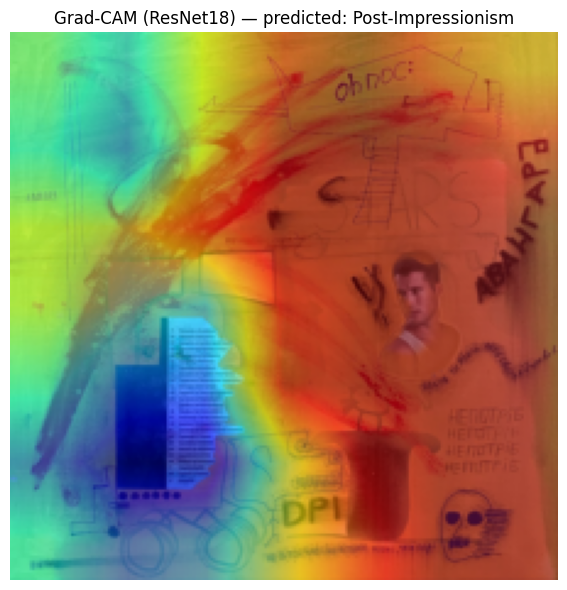

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms, models
from PIL import Image

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===== Load model (pretrained ResNet18) =====
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 6)  # if you have 6 classes
resnet.load_state_dict(torch.load("../models/resnet18.pt", map_location=device))
resnet = resnet.to(device)

# ===== Classes (example) =====
full_dataset = type('', (), {})()  # create a dummy object
full_dataset.classes = ['Baroque', 'Cubism', 'Impressionism', 'Northern Renaissance', 'Post-Impressionism', 'Romanticism']

# ===== Image preparation =====
img_path = "../data/sample_data/sample_data4.jpg"  # path to the image
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
input_tensor = transform(img).unsqueeze(0).to(device)

# ===== Containers =====
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# ===== ResNet18 layer =====
target_layer = resnet.layer4[1].conv2
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)

# ===== Forward pass =====
resnet.eval()
activations.clear()
gradients.clear()

output = resnet(input_tensor)
pred_class = output.argmax().item()
print("Predicted class:", full_dataset.classes[pred_class])

resnet.zero_grad()
output[0, pred_class].backward()

# ===== Grad-CAM =====
act = activations[0].squeeze(0)
grad = gradients[0].squeeze(0)
weights = grad.mean(dim=(1, 2))

cam = torch.zeros(act.shape[1:], dtype=torch.float32).to(device)
for i, w in enumerate(weights):
    cam += w * act[i]
cam = torch.relu(cam)
cam -= cam.min()
cam /= cam.max()
cam = cam.detach().cpu().numpy()

# ===== Visualization =====
def show_cam_on_image(img_tensor, mask):
    img_np = (img_tensor.squeeze().cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
    img_np = np.clip(img_np, 0, 1)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255
    cam_img = heatmap + img_np
    cam_img = cam_img / np.max(cam_img)
    return np.uint8(255 * cam_img)
cam = cv2.resize(cam, (224, 224))  # scale the mask to the size of the image

result = show_cam_on_image(input_tensor, cam)

plt.figure(figsize=(8, 6))
plt.imshow(result)
plt.axis("off")
plt.title(f"Grad-CAM (ResNet18) — predicted: {full_dataset.classes[pred_class]}")
plt.tight_layout()
plt.show()

# ===== Remove hooks =====
forward_handle.remove()
backward_handle.remove()


## Grad-CAM Visualization on Graffiti Image

To better understand why the ResNet18 model predicted the graffiti photo as **Post-Impressionism**, I applied Grad-CAM to visualize the regions of the image that influenced the decision the most.

The heatmap upper overlays the model’s "attention" on top of the original image:

From the visualization, it’s clear that the model focused strongly on:
- The **warm-toned right side** of the image (yellow-red region)
- The **central figure** and its surroundings
- Some areas containing **text, form, and expressive brush strokes**

These regions resemble characteristics often found in Post-Impressionist works — vivid color transitions, loose structure, and symbolic or emotional elements. It’s interesting to observe that even though this is a piece of graffiti, the model interpreted its color and texture dynamics as stylistically close to Post-Impressionism.

This example shows how explainability tools like Grad-CAM help verify and interpret model decisions, especially on non-standard inputs.
